# Torchlurk Example

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.insert(1,"src")
from torchlurk.Torchlurk import Lurk
from torchlurk.misc_funcs import clean_bw_imgs,sample_imagefolder,plot_hist,crop_imgs,rename_directories,check_imgs_integrity
from torchlurk.get_models import get_alex_places
from torchvision import transforms,models
import os
import pandas as pd

## ImageNet

### Preprocessing

At that stage, Download the tinyimagenet dataset on [this link](https://www.kaggle.com/ifigotin/imagenetmini-1000#n01440764_10470.JPEG) and place it in the directory data (s.t the path looks like `data/tinyimagenet/rest_of_path`

First we center-crop inplace the images to the desired shape

In [ ]:
crop_imgs("./bigdata/imagenet-mini/train/")

Once the dataset is downloaded, we need to get rid of a few buggy bw images: 

In [ ]:
clean_bw_imgs("./bigdata/imagenet-mini/train/")

You might want to work on a subset of tinyimagenet for computations reason.

In [ ]:
sample_imagefolder("bigdata/imagenet-mini/train/","static/data/imagenet10classes/images",num_dir=20,img_num_per_dir=5)

In [ ]:
check_imgs_integrity("data/imagenet-mini/train/")

Run this cell in order to instanciate the dic translating titles (n023424) to classes (penguin)

In [ ]:
infos = pd.read_csv("./bigdata/labels_imagenet.txt",sep=" ",header=None)
dic = infos.set_index(0)[1].to_dict()

In [ ]:
rename_directories('./data/imagenet-mini/train',dic)

### Instanciation

In [ ]:
model_vgg16 = models.vgg16(pretrained=True)
# same preprocess used as vgg16
preprocess = transforms.Compose([
    transforms.CenterCrop(224), 
    transforms.ToTensor()
    ,transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

You can either start from scratch...

In [ ]:
lurker = Lurk(model_vgg16,
              preprocess,
              save_gen_imgs_dir='./results/trash/',
              save_json_path='./saved_model/vgg16_imagenettrash.json',
              imgs_src_dir="./data/imagenet-mini/train/",
              side_size=224,title2class=dic)

Or load a precomputed json:

# Instanciation

In [19]:
lurker = Lurk(model_vgg16,
              preprocess,
              save_gen_imgs_dir='./results/vgg16_imagenet/',
              save_json_path='./saved_model/vgg16_imagenettrash.json',
              load_json_path='./saved_model/vgg16_imagenet.json',
              imgs_src_dir="./data/imagenet-mini/train/",
              side_size=224,title2class=dic)

Loading from json done!
json saving done!


## Computations

### Serving

In [20]:
lurker.serve()

 * Serving Flask app "torchlurk.app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [28/May/2020 15:53:42] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2020 15:53:43] "GET /saved_model/vgg16_imagenettrash.json HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2020 15:53:51] "GET /results/vgg16_imagenet/avg_act/Conv2d_5/28/n02206856_8505.JPEG HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2020 15:53:51] "GET /results/vgg16_imagenet/avg_act/Conv2d_5/28/n02281406_6632.JPEG HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2020 15:53:51] "GET /results/vgg16_imagenet/avg_act/Conv2d_5/28/n02395406_10062.JPEG HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2020 15:53:51] "GET /results/vgg16_imagenet/avg_act/Conv2d_5/28/n02095570_6491.JPEG HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2020 15:53:51] "GET /results/vgg16_imagenet/avg_act/Conv2d_5/28/n02177972_12817.JPEG HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2020 15:53:51] "GET /results/vgg16_imagenet/avg_act/Conv2d_5/28/n02281406_1020.JPEG HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2020 15:53:51] "GET /results/v

In [21]:
lurker.end_serve()

### Compute top Images

We compute the average/maximum activation images from the train set:

In [ ]:
lurker.compute_top_imgs()

And plot the "most activating" classes w.r.t a metric(max or avg) for a given filter

### Compute Layer Visualizations

Possibility to compute the layer visualization: the following will compute the layer visualization for all cells.

In [ ]:
lurker.compute_viz(first_n_imgs=64)

While we can compute it for a specific combination of layers/indexes

In [ ]:
lurker.compute_layer_viz(layer_indx = 0,filter_indexes=[0,2,4,6])

### Compute Gradients

And the respective gradients w.r.t the most activating images

In [ ]:
lurker.compute_grads(first_n_imgs=64)

In [ ]:
lurker.save_to_json()

### Notebook Visualization

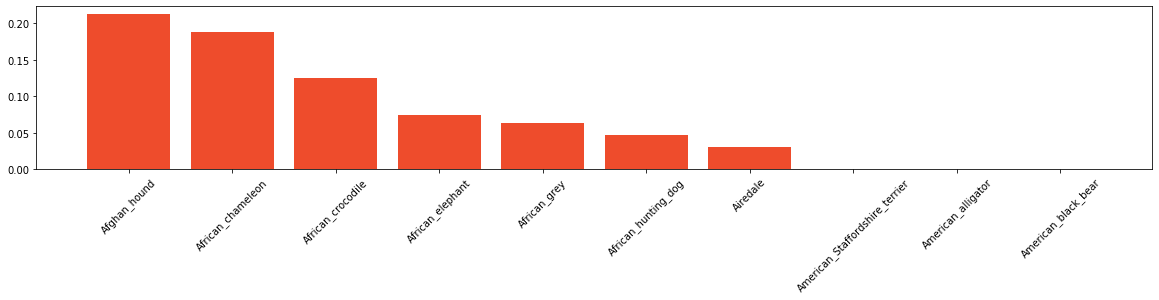

In [22]:
lurker.plot_hist(10,0,"avg",num_classes=10)

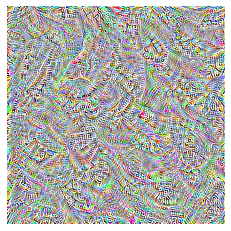

In [23]:
lurker.plot_filter_viz(12,7)

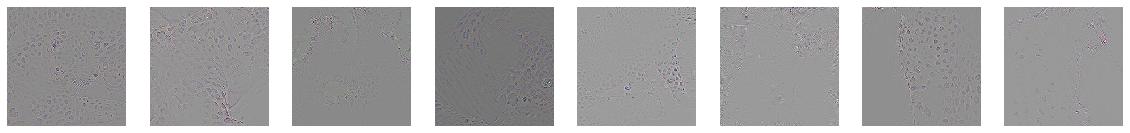

In [24]:
lurker.plot_top("avg",layer_indx=12,filt_indx=7,plot_imgs=False,plot_grad=True)

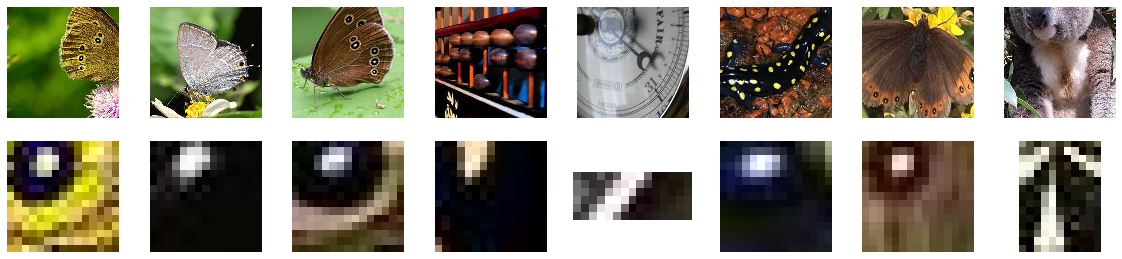

In [25]:
lurker.plot_crop(layer_indx=2,filt_indx=15)

In [ ]:
lurker.plot_crop(layer_indx=0,filt_indx=7)

### Saving/Loading

How to save/load the lurker in a convenient manner..

In [ ]:
lurker.save_to_dill("./results/vgg16_imagenet.pickle")

In [ ]:
lurker2 = Lurk.load_from_dill("./results/vgg16_imagenet.pickle")

If you wish to load a precomputed json, just add the `load_path` attribute. Watch out, it needs to be coherent with the folder name.

In [ ]:
lurker2 = Lurk(model,
               preprocess,
               save_gen_imgs_dir='./results/trash/',
               save_json_path='./saved_model/new_vgg16.json',
               imgs_src_dir="./data/imagenet10classes/images",
               load_json_path='./saved_model/vgg16_imagenet.json',
               side_size=224)